In [0]:
from google.colab import drive
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from time import time
import matplotlib

from tensorflow.keras import models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Concatenate, Average
from tensorflow.keras.models import model_from_json
from tensorflow.keras import callbacks

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import lightgbm as lgb

In [0]:
drive.mount('/content/drive', force_remount=False)

In [0]:
# Change this to the path where this folder is located in your Drive
os.chdir('/content/drive/My Drive/MLHC/project_1/')

In [0]:
# Our models
from CNN_arch import CNN
from RNN_arch import RNN
from CRNN_arch import CRNN
from CNNR_arch import CNNR

## Load & inspect datasets

### MIT Dataset

In [0]:
df_train = pd.read_csv("data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("data/mitbih_test.csv", header=None)

Y_mit = np.array(df_train[187].values).astype(np.int8)
X_mit = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test_mit = np.array(df_test[187].values).astype(np.int8)
X_test_mit = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [0]:
print(len(Y_mit), "training samples and", len(Y_test_mit), "testing samples of shape", X_mit[0].shape)

87554 training samples and 21892 testing samples of shape (187, 1)


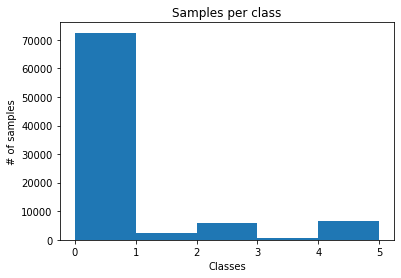

In [0]:
plt.hist(Y_mit, bins=range(len(np.bincount(Y_mit))+1))
plt.title("Samples per class")
plt.xlabel("Classes")
plt.ylabel("# of samples")
plt.show()

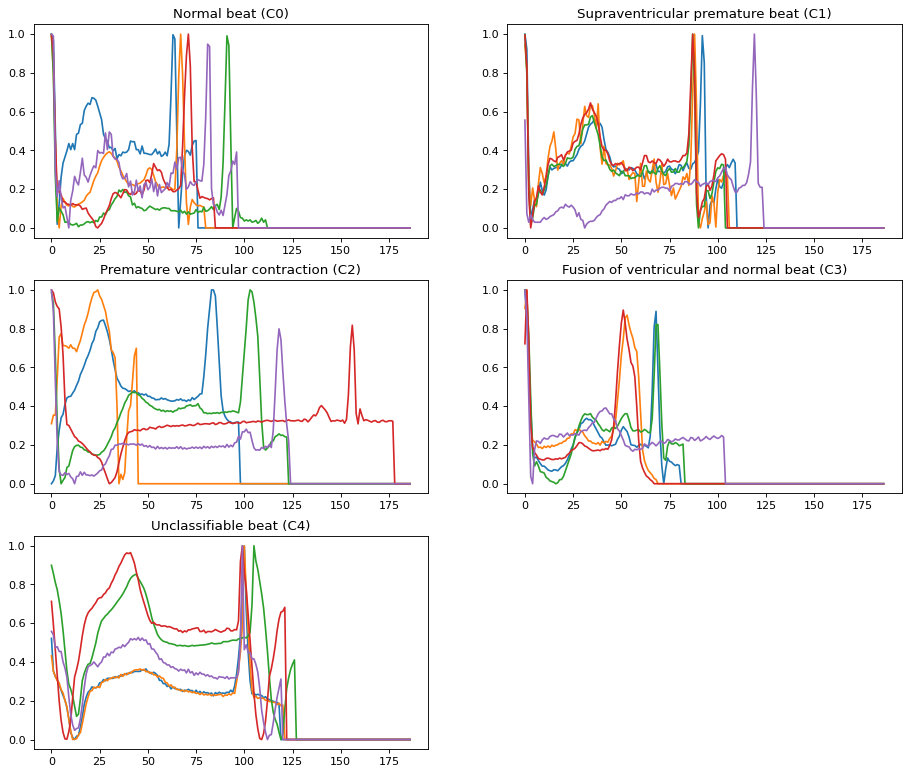

In [0]:
def plot_signal(class_number, title, plot_index):
    plt.subplot(3, 2, plot_index)
    tmp = np.squeeze(X_mit[Y_mit==class_number])
    plt.title(title)
    plt.plot(random.choice(tmp))
    plt.plot(random.choice(tmp))
    plt.plot(random.choice(tmp))
    plt.plot(random.choice(tmp))
    plt.plot(random.choice(tmp))

plt.figure(figsize=(14, 12), dpi= 80, facecolor='w', edgecolor='k')
plot_signal(0, "Normal beat (C0)", 1)
plot_signal(1, "Supraventricular premature beat (C1)", 2)
plot_signal(2, "Premature ventricular contraction (C2)", 3)
plot_signal(3, "Fusion of ventricular and normal beat (C3)", 4)
plot_signal(4, "Unclassifiable beat (C4)", 5)

### PTB Dataset

In [0]:
df_1 = pd.read_csv("data/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y_ptb = np.array(df_train[187].values).astype(np.int8)
X_ptb = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test_ptb = np.array(df_test[187].values).astype(np.int8)
X_test_ptb = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [0]:
print(len(Y_ptb), "training samples and", len(Y_test_ptb), "testing samples of shape", X_ptb[0].shape)

11641 training samples and 2911 testing samples of shape (187, 1)


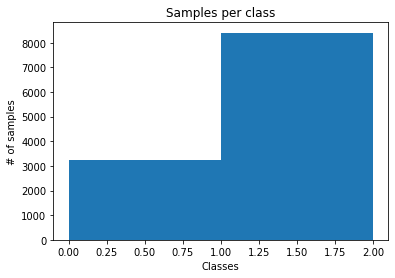

In [0]:
plt.hist(Y_ptb, bins=range(len(np.bincount(Y_ptb))+1))
plt.title("Samples per class")
plt.xlabel("Classes")
plt.ylabel("# of samples")
plt.show()

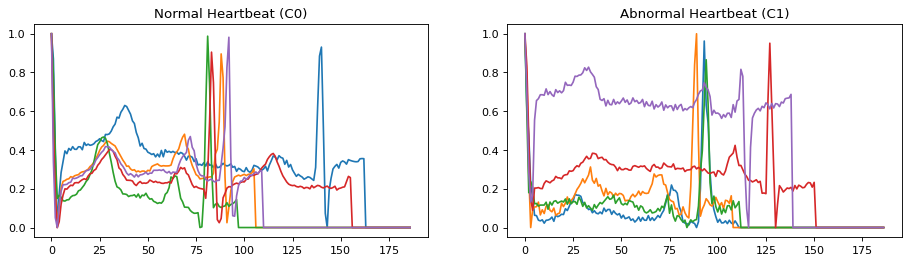

In [0]:
def plot_signal(class_number, title, plot_index):
    plt.subplot(3, 2, plot_index)
    tmp = np.squeeze(X_ptb[Y_ptb==class_number])
    plt.title(title)
    plt.plot(random.choice(tmp))
    plt.plot(random.choice(tmp))
    plt.plot(random.choice(tmp))
    plt.plot(random.choice(tmp))
    plt.plot(random.choice(tmp))

    
plt.figure(figsize=(14, 12), dpi= 80, facecolor='w', edgecolor='k')
plot_signal(0, "Normal Heartbeat (C0)", 1)
plot_signal(1, "Abnormal Heartbeat (C1)", 2)

## Setup

### Wrapper Class
This class will help us train, evaluate and compare our models

In [0]:
class Model_Wrapper:
    def __init__(self, model_class):
        self.model_class = model_class
        self.model = model_class.model
        self.name = model_class.name
        self.dir = './models/'+model_class.name+'/'
        if not os.path.exists(self.dir):
            os.makedirs(self.dir)
  
    def set_weights(self):
        self.model.load_weights(self.dir+self.name+'_weights.h5')

    def save_weights(self):
        self.model.save_weights(self.dir+self.name+'_weights.h5')

    def set_model(self):
        # load json and create model
        json_file = open(self.dir+self.name+"_model.json", 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        self.set_weights()
        print("Loaded", self.name, "from disk")

    def save_model(self):
        model_json = self.model.to_json()
        with open(self.dir+self.name+"_model.json", "w") as json_file:
            json_file.write(model_json)
        self.save_weights()
        print("Saved", self.name, "to disk")

    def train(self, X, Y, shuffle=True, epochs=100, batch_size=None, save=True, verbose=1, validation_split=.1):
        cbs = []
        cbs.append(EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1))
        cbs.append(ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2))
        if save:
            cbs.append(callbacks.TensorBoard(log_dir=self.dir+'log/'))
            cbs.append(ModelCheckpoint(self.dir+self.name+'_weights.h5', monitor='val_acc', verbose=verbose, save_best_only=True, mode='max'))
        self.model.fit(X, Y,
                shuffle=shuffle,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=cbs,
                verbose=verbose,
                validation_split=validation_split)

### Helper functions

Takes a model wrapper (class defined above) and evaluates its performance on the provided test set, outputs the accuracy, f1 score, confusion matrix and summary of the model (also AUROC and AUPRC for binary classifiers) and saves the results in a txt file if required.

In [0]:
def evaluate_model(model_wrapper, X_test, Y_test, save=True):
    pred_test = model_wrapper.model.predict(X_test)
    if pred_test.shape[1] > 1:
        pred_test = np.argmax(pred_test, axis=1)
    else:
        pred_test = np.round(pred_test).reshape(-1).astype(int)
    
    f1 = f1_score(Y_test, pred_test, average="macro")
    acc = accuracy_score(Y_test, pred_test)

    classes = np.bincount(pred_test).size
    if classes <= 2:auroc = roc_auc_score(Y_test, pred_test)
    if classes <= 2:auprc = average_precision_score(Y_test, pred_test)
    cm = confusion_matrix(Y_test, pred_test)
    
    print("\n=================================================================")
    print("\nAccuracy:", round(acc, 5))
    print("F1:      ", round(f1, 5))
    if classes <= 2:print("AUROC    ", round(auroc, 5))
    if classes <= 2:print("AUPRC    ", round(auprc, 5))
    print("Confusion matrix:")
    print(cm)
    print("Accuracy per class")
    print(cm.diagonal() / np.sum(cm, axis=1))
    print("\n=================================================================\n")
    
    if save:
        with open(model_wrapper.dir + 'report.txt','a') as fh:
            fh.write("\n=================================================================")
            fh.write("\nAccuracy:      "+str(acc)+"\n")
            fh.write("F1:            "+str(f1)+"\n")
            fh.write("Confusion mat:\n "+str(cm)+"\n")
            fh.write("Acc per class: "+str(cm.diagonal() / np.sum(cm, axis=1))+"\n")
            if classes <= 2:fh.write("AUROC:    "+str(auroc)+"\n")
            if classes <= 2:fh.write("AUPRC:    "+str(auprc)+"\n\n")
            fh.write("\n=================================================================\n")
        with open(model_wrapper.dir + 'summary.txt','w') as fh:
            if type(model_wrapper.model.summary) is not str: model_wrapper.model.summary(print_fn=lambda x: fh.write(x + '\n'))
            else: fh.write(model_wrapper.model.summary)
    return (f1, acc)

Runs K-Fold cross-validation and pretty-prints intermediate results.

In [0]:
def cross_validation(model_wrapper, X, Y, folds=5, shuffle=True, epochs=100, batch_size=None, verbose=0, validation_split=.1):
    kf = KFold(n_splits=folds)
    i = 0.
    f1_a = 0
    acc_a = 0
    for train_index, test_index in kf.split(X):
        print("Iteration", int(i+1))
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model_wrapper.model_class.model = model_wrapper.model_class.get_model()
        model_wrapper.model_class.compile_model()
        cv_model = Model_Wrapper(model_wrapper.model_class)
        cv_model.train(X_train, Y_train, epochs=epochs, batch_size=batch_size, save=False, verbose=verbose, shuffle=shuffle, validation_split=validation_split)
        f1, acc = evaluate_model(X_test, Y_test, save=False)
        f1_a += f1
        acc_a += acc
        i += 1
    print("\n=================================================================")
    print("\nAverage Accuracy:", round(acc_a/i, 5))
    print("Average F1:      ", round(f1_a/i, 5))
    print("\n=================================================================\n")

## Baseline

### MIT Dataset

In [0]:
# Change 'Baseline_MIT' to any other name if you wish to re-run our code and train a new model
cnn_mit_wrapper = Model_Wrapper(CNN('Baseline_MIT', 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_mit_wrapper.model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "Baseline_MIT"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 183, 16)           96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 89, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 87, 32)            1568      
_______________________________________

In [0]:
cnn_mit_wrapper.train(X_mit, Y_mit)
cnn_mit_wrapper.set_weights()
cnn_mit_wrapper.save_model()

In [0]:
cnn_mit_wrapper.set_model()
evaluate_model(cnn_mit_wrapper, X_test_mit, Y_test_mit)

Loaded Baseline_MIT from disk


Accuracy: 0.9841
F1:       0.9125
Confusion matrix:
[[18056    38    17     3     4]
 [  128   413    14     0     1]
 [   54     4  1374    10     6]
 [   23     0    20   119     0]
 [   23     0     3     0  1582]]
Accuracy per class
[0.99657799 0.74280576 0.94889503 0.7345679  0.98383085]




(0.9125009852594997, 0.9841037822035447)

### PTB Dataset

In [0]:
# Change 'Baseline_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
cnn_ptb_wrapper = Model_Wrapper(CNN('Baseline_PTB', 1, 'binary_crossentropy', 'sigmoid'))
cnn_ptb_wrapper.model.summary()

Model: "Baseline_PTB"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 183, 16)           96        
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 89, 16)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 89, 16)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 87, 32)            1568      
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 85, 32)           

In [0]:
cnn_ptb_wrapper.train(X_ptb, Y_ptb)
cnn_ptb_wrapper.set_weights()
cnn_ptb_wrapper.save_model()

In [0]:
cnn_ptb_wrapper.set_model()
evaluate_model(cnn_ptb_wrapper, X_test_ptb, Y_test_ptb)

Loaded Baseline_PTB from disk


Accuracy: 0.98969
F1:       0.98713
AUROC     0.98602
AUPRC     0.98992
Confusion matrix:
[[ 791   18]
 [  12 2090]]
Accuracy per class
[0.97775031 0.99429115]




(0.9871318437137149, 0.9896942631398145)

## Our Models

### LSTM
Bidirectional LSTM with dense layer.

#### MIT Dataset

In [0]:
# Change 'RNN_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
lstm_mit_wrapper = Model_Wrapper(RNN('RNN_MIT_Bidirectional',  5, 'sparse_categorical_crossentropy', 'softmax', 200, 150))
lstm_mit_wrapper.model.summary()

Model: "RNN_MIT_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 300)               183600    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
out_layer (Dense)            (None, 5)                 1005      
Total params: 244,805
Trainable params: 244,805
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm_mit_wrapper.train(X_mit, Y_mit, batch_size=100)
lstm_mit_wrapper.set_weights()
lstm_mit_wrapper.save_model()

In [0]:
lstm_mit_wrapper.set_model()
evaluate_model(lstm_mit_wrapper, X_test_mit, Y_test_mit)

Loaded RNN_MIT_Bidirectional from disk


Accuracy: 0.98634
F1:       0.91981
Confusion matrix:
[[18044    28    29     9     8]
 [   95   449     9     2     1]
 [   45     0  1383    18     2]
 [   24     1    13   124     0]
 [   12     1     2     0  1593]]
Accuracy per class
[0.99591566 0.80755396 0.9551105  0.7654321  0.99067164]




(0.9198089093766804, 0.9863420427553444)

#### PTB Dataset

In [0]:
# Change 'RNN_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
lstm_ptb_wrapper = Model_Wrapper(RNN('RNN_PTB_Bidirectional', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
lstm_ptb_wrapper.model.summary()

Model: "RNN_PTB_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 300)               183600    
_________________________________________________________________
dense_3 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 201       
Total params: 244,001
Trainable params: 244,001
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm_ptb_wrapper.train(X_ptb, Y_ptb, validation_split=.2)
lstm_ptb_wrapper.set_weights()
lstm_ptb_wrapper.save_model()

In [0]:
lstm_ptb_wrapper.set_model()
evaluate_model(lstm_ptb_wrapper, X_test_ptb, Y_test_ptb)

Loaded RNN_PTB_Bidirectional from disk


Accuracy: 0.94641
F1:       0.93329
AUROC     0.93362
AUPRC     0.95427
Confusion matrix:
[[ 732   77]
 [  79 2023]]
Accuracy per class
[0.90482077 0.96241675]




(0.9332892626086344, 0.9464101683270354)

### CRNN
Bidirectional GRU with 2 convolutional layers on top (taken from baseline CNN) and a dense layer before the output

#### MIT Dataset

In [0]:
# Change 'Conv_RNN_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
convrnn_mit_wrapper = Model_Wrapper(CRNN('Conv_RNN_MIT_Bidirectional', 5, 'sparse_categorical_crossentropy', 'softmax', 200, 150))
convrnn_mit_wrapper.model.summary()

Model: "Conv_RNN_MIT_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 185, 16)           64        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 183, 16)           784       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 91, 16)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 91, 16)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 89, 32)            1568      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 87, 

In [0]:
convrnn_mit_wrapper.train(X_mit, Y_mit)
convrnn_mit_wrapper.set_weights()
convrnn_mit_wrapper.save_model()

In [0]:
convrnn_mit_wrapper.set_model()
evaluate_model(convrnn_mit_wrapper, X_test_mit, Y_test_mit)

Loaded Conv_RNN_MIT_Bidirectional from disk


Accuracy: 0.98776
F1:       0.92468
Confusion matrix:
[[18057    34    13    11     3]
 [  100   446     8     1     1]
 [   29     6  1392    17     4]
 [   19     0    13   130     0]
 [    9     0     0     0  1599]]
Accuracy per class
[0.99663318 0.80215827 0.96132597 0.80246914 0.99440299]




(0.9246823476989399, 0.9877580851452585)

#### PTB Dataset

In [0]:
# Change 'Conv_RNN_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
convrnn_ptb_wrapper = Model_Wrapper(CRNN('Conv_RNN_PTB_Bidirectional', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
convrnn_ptb_wrapper.model.summary()

Model: "Conv_RNN_PTB_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 185, 16)           64        
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 183, 16)           784       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 91, 16)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 91, 16)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 89, 32)            1568      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 87, 

In [0]:
convrnn_ptb_wrapper.train(X_ptb, Y_ptb, validation_split=.2)
convrnn_ptb_wrapper.set_weights()
convrnn_ptb_wrapper.save_model()

In [0]:
convrnn_ptb_wrapper.set_model()
evaluate_model(convrnn_ptb_wrapper, X_test_ptb, Y_test_ptb)

Loaded Conv_RNN_PTB_Bidirectional from disk


Accuracy: 0.99382
F1:       0.99229
AUROC     0.99154
AUPRC     0.99387
Confusion matrix:
[[ 798   11]
 [   7 2095]]
Accuracy per class
[0.98640297 0.99666984]




(0.9922850085515993, 0.9938165578838887)

### CNN with Residuals

#### MIT Dataset

In [0]:
# Change 'CNN_RES_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
cnn_res_mit_wrapper = Model_Wrapper(CNNR('CNN_RES_MIT', 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_res_mit_wrapper.model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 183, 32)      192         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 183, 32)      128         conv1d_16[0][0]                  
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 183, 32)      0           batch_normalization_2[0][0]      
______________________________________________________________________________________________

In [0]:
cnn_res_mit_wrapper.train(X_mit, Y_mit)
cnn_res_mit_wrapper.set_weights()
cnn_res_mit_wrapper.save_model()

In [0]:
cnn_res_mit_wrapper.set_model()
evaluate_model(cnn_res_mit_wrapper, X_test_mit, Y_test_mit)

Loaded CNN_RES_MIT from disk


Accuracy: 0.98506
F1:       0.9146
Confusion matrix:
[[18066    23    18     8     3]
 [  154   391    10     1     0]
 [   42     1  1387    15     3]
 [   13     0    19   130     0]
 [   15     0     1     1  1591]]
Accuracy per class
[0.99712993 0.70323741 0.95787293 0.80246914 0.98942786]




(0.9145959401334487, 0.9850630367257446)

#### PTB Dataset

In [0]:
# Change 'CNN_RES_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
cnn_res_ptb_wrapper = Model_Wrapper(CNNR('CNN_RES_PTB', 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_wrapper.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 183, 32)      192         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 183, 32)      128         conv1d_28[0][0]                  
__________________________________________________________________________________________________
re_lu_8 (ReLU)                  (None, 183, 32)      0           batch_normalization_11[0][0]     
____________________________________________________________________________________________

In [0]:
cnn_res_ptb_wrapper.train(X_ptb, Y_ptb, validation_split=.2)
cnn_res_ptb_wrapper.set_weights()
cnn_res_ptb_wrapper.save_model()

In [0]:
cnn_res_ptb_wrapper.set_model()
evaluate_model(cnn_res_ptb_wrapper, X_test_ptb, Y_test_ptb)

Loaded CNN_RES_PTB from disk


Accuracy: 0.99691
F1:       0.99615
AUROC     0.99634
AUPRC     0.99744
Confusion matrix:
[[ 805    4]
 [   5 2097]]
Accuracy per class
[0.99505562 0.99762131]




(0.9961498426739217, 0.9969082789419443)

## Transfer Learning

### Baseline

In [0]:
# Pretrained model to get the weights from. Change 'Baseline_MIT' to the name of your pretrained model.
cnn_mit_wrapper = Model_Wrapper(CNN('Baseline_MIT', 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_mit_wrapper.set_model()

# Change 'Baseline_Transfer_Retrain' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
cnn_transfer = Model_Wrapper(CNN('Baseline_Transfer_Retrain', 1, 'binary_crossentropy', 'sigmoid'))

Loaded Baseline_MIT from disk


In [0]:
# Copy all weights from the pretrained model, except for the last 3 dense layers
# If you want to freeze the pretrained layers, set trainable to False below
for i in range(17):
    cnn_transfer.model.layers[i].set_weights(cnn_mit_wrapper.model.layers[i].get_weights())
    cnn_transfer.model.layers[i].trainable = True   # set this to False if you want to reproduce the 'Freeze' results
cnn_transfer.model_class.compile_model()

In [0]:
# Check number of untrainable parameters, important if you set trainable layers to False above
cnn_transfer.model.summary()

Model: "Baseline_Transfer_Retrain"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 183, 16)           96        
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 179, 16)           1296      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 89, 16)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 89, 16)            0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 87, 32)            1568      
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 85, 3

In [0]:
# Train and save model
cnn_transfer.train(X_ptb, Y_ptb)
cnn_transfer.set_weights()
cnn_transfer.save_model()

In [0]:
# Evaluate model
cnn_transfer.set_model()
evaluate_model(cnn_transfer, X_test_ptb, Y_test_ptb)

Loaded Baseline_Transfer_Retrain from disk


Accuracy: 0.9921
F1:       0.99015
AUROC     0.98997
AUPRC     0.99287
Confusion matrix:
[[ 797   12]
 [  11 2091]]
Accuracy per class
[0.98516687 0.99476689]




(0.9901532248398224, 0.9920989350738578)

### LSTM

In [0]:
# Pretrained model to get the weights from. Change 'RNN_MIT' to the name of your pretrained model.
lstm_mit_wrapper = Model_Wrapper(RNN('RNN_MIT_Bidirectional', 5, 'sparse_categorical_crossentropy', 'softmax', 200, 150))
lstm_mit_wrapper.set_model()

# Change 'RNN_Transfer_Retrain' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
lstm_transfer = Model_Wrapper(RNN('RNN_Transfer_Retrain_Bidirectional', 1, 'binary_crossentropy', 'sigmoid', 200, 150))

Loaded RNN_MIT_Bidirectional from disk


In [0]:
# Copy all weights from the pretrained model, except for the last 2 dense layers
# If you want to freeze the pretrained layers, set trainable to False below
for i in range(2):
    lstm_transfer.model.layers[i].set_weights(lstm_mit_wrapper.model.layers[i].get_weights())
    lstm_transfer.model.layers[i].trainable = True  # set this to False if you want to reproduce the 'Freeze' results
lstm_transfer.model_class.compile_model()

In [0]:
# Check number of untrainable parameters, important if you set trainable layers to False above
lstm_transfer.model.summary()

Model: "RNN_Transfer_Retrain_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 187, 1)]          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 200)               82400     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_21 (Dropout)         (None, 200)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 201       
Total params: 122,801
Trainable params: 122,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Train and save model
lstm_transfer.train(X_ptb, Y_ptb, validation_split=.2)
lstm_transfer.set_weights()
lstm_transfer.save_model()

In [0]:
# Evaluate model
lstm_transfer.set_model()
evaluate_model(lstm_transfer, X_test_ptb, Y_test_ptb)

Loaded RNN_Transfer_Retrain_Bidirectional from disk


Accuracy: 0.98798
F1:       0.98506
AUROC     0.98635
AUPRC     0.99061
Confusion matrix:
[[ 795   14]
 [  21 2081]]
Accuracy per class
[0.98269468 0.99000951]




(0.9850611242462564, 0.9879766403297836)

### CRNN

In [0]:
# Pretrained model to get the weights from. Change 'Conv_RNN_MIT' to the name of your pretrained model.
convrnn_mit_wrapper = Model_Wrapper(CRNN('Conv_RNN_MIT_Bidirectional', 5, 'sparse_categorical_crossentropy', 'softmax', 200, 150))
convrnn_mit_wrapper.set_model()

# Change 'Conv_RNN_Transfer_Retrain' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
convrnn_transfer = Model_Wrapper(CRNN('Conv_RNN_Transfer_Retrain_Bidirectional', 1, 'binary_crossentropy', 'sigmoid', 200, 100))

Loaded Conv_RNN_MIT_Bidirectional from disk


In [0]:
# Copy all weights from the pretrained model, except for the last 2 dense layers
# If you want to freeze the pretrained layers, set trainable to False below
for i in range(11):
    convrnn_transfer.model.layers[i].set_weights(convrnn_mit_wrapper.model.layers[i].get_weights())
    convrnn_transfer.model.layers[i].trainable = True   # set this to False if you want to reproduce the 'Freeze' results
convrnn_transfer.model_class.compile_model()

In [0]:
# Check number of untrainable parameters, important if you set trainable layers to False above
convrnn_transfer.model.summary()

Model: "Conv_RNN_Transfer_Retrain_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 187, 1)]          0         
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 185, 16)           64        
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 183, 16)           784       
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 91, 16)            0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 91, 16)            0         
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 89, 32)            1568      
_________________________________________________________________
conv1d_63 (Conv1D)         

In [0]:
# Train and save model
convrnn_transfer.train(X_ptb, Y_ptb, validation_split=.2)
convrnn_transfer.set_weights()
convrnn_transfer.save_model()

In [0]:
# Evaluate model
convrnn_transfer.set_model()
evaluate_model(convrnn_transfer, X_test_ptb, Y_test_ptb)

Loaded Conv_RNN_Transfer_Retrain_Bidirectional from disk


Accuracy: 0.99656
F1:       0.99571
AUROC     0.99496
AUPRC     0.99628
Confusion matrix:
[[ 802    7]
 [   3 2099]]
Accuracy per class
[0.99134734 0.99857279]




(0.9957138936397775, 0.9965647543799382)

### CNN with Residuals

In [0]:
# Pretrained model to get the weights from. Change 'Conv_RNN_MIT' to the name of your pretrained model.
cnn_res_ptb_wrapper = Model_Wrapper(CNNR('CNN_RES_MIT', 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_res_ptb_wrapper.set_model()

# Change 'CNN_RES_Transfer_Retrain' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
cnn_res_transfer = Model_Wrapper(CNNR('CNN_RES_Transfer_Retrain', 1, 'binary_crossentropy', 'sigmoid'))

Loaded CNN_RES_MIT from disk


In [0]:
# Copy all weights from the pretrained model, except for the last 3 dense layers
# If you want to freeze the pretrained layers, set trainable to False below
for i in range(36):
    cnn_res_transfer.model.layers[i].set_weights(cnn_res_ptb_wrapper.model.layers[i].get_weights())
    cnn_res_transfer.model.layers[i].trainable = True   # set this to False if you want to reproduce the 'Freeze' results
cnn_res_transfer.model_class.compile_model()

In [0]:
# Check number of untrainable parameters, important if you set trainable layers to False above
cnn_res_transfer.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_76 (Conv1D)              (None, 183, 32)      192         input_19[0][0]                   
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 183, 32)      128         conv1d_76[0][0]                  
__________________________________________________________________________________________________
re_lu_24 (ReLU)                 (None, 183, 32)      0           batch_normalization_31[0][0]     
____________________________________________________________________________________________

In [0]:
# Train and save model
cnn_res_transfer.train(X_ptb, Y_ptb, validation_split=.2)
cnn_res_transfer.set_weights()
cnn_res_transfer.save_model()

In [0]:
# Evaluate model
cnn_res_transfer.set_model()
evaluate_model(cnn_res_transfer, X_test_ptb, Y_test_ptb)

Loaded CNN_RES_Transfer_Retrain from disk


Accuracy: 0.99553
F1:       0.99443
AUROC     0.99349
AUPRC     0.99521
Confusion matrix:
[[ 800    9]
 [   4 2098]]
Accuracy per class
[0.98887515 0.99809705]




(0.994425931973186, 0.9955341806939196)

## Ensembling
Use multiple, well performing models and combine their strengths to create a new, superior model.

### AdaBoost
AdaBoost classifier usiing random forest as base classifier

In [0]:
def evaluate_ensemble_model(model, X_test, Y_test):
    pred_test = model.predict(np.squeeze(X_test))
    
    f1 = f1_score(Y_test, pred_test, average="macro")
    acc = accuracy_score(Y_test, pred_test)

    classes = np.bincount(pred_test).size
    if classes <= 2:auroc = roc_auc_score(Y_test, pred_test)
    if classes <= 2:auprc = average_precision_score(Y_test, pred_test)
    cm = confusion_matrix(Y_test, pred_test)
    
    print("\n=================================================================")
    print("\nAccuracy:", round(acc, 5))
    print("F1:      ", round(f1, 5))
    if classes <= 2:print("AUROC    ", round(auroc, 5))
    if classes <= 2:print("AUPRC    ", round(auprc, 5))
    print("Confusion matrix:")
    print(cm)
    print("Accuracy per class")
    print(cm.diagonal() / np.sum(cm, axis=1))
    print("\n=================================================================\n")

#### MIT Dataset

In [0]:
rf = RandomForestClassifier(max_depth=100, criterion='entropy', random_state=5, bootstrap=True)
clf = AdaBoostClassifier(base_estimator=rf, n_estimators=100, random_state=13)

clf.fit(np.squeeze(X_mit), Y_mit)

evaluate_ensemble_model(clf, X_test_mit, Y_test_mit)

#### PTB Dataset

In [0]:
rf = RandomForestClassifier(max_depth=100, criterion='entropy', random_state=5, bootstrap=True)
clf = AdaBoostClassifier(base_estimator=rf, n_estimators=100, random_state=13)

clf.fit(np.squeeze(X_ptb), Y_ptb)

evaluate_ensemble_model(clf, X_test_ptb, Y_test_ptb)



Accuracy: 0.97011
F1:       0.96226
AUROC     0.95611
AUPRC     0.96837
Confusion matrix:
[[ 748   61]
 [  26 2076]]
Accuracy per class
[0.92459827 0.98763083]




### Averaging
Take average of all models' outputs

In [0]:
class Averaging:
    def __init__(self, name, models: list):
        self.name = name
        self.models = models
        self.model = self.get_model()

    def get_model(self):
        X = Input(shape=(187,1))
        outputs = [model(X) for model in self.models]
        y = Average(name='average')(outputs)
        
        model = models.Model(X, y, name='average ensemble')
        
        return model

#### MIT Dataset

In [0]:
# Load all models to be ensembled

cnn_mit_avg_wrapper = Model_Wrapper(CNN('Baseline_MIT', 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_mit_avg_wrapper.set_model()

lstm_mit_avg_wrapper = Model_Wrapper(RNN('RNN_MIT_Bidirectional', 5, 'sparse_categorical_crossentropy', 'softmax', 200, 150))
lstm_mit_avg_wrapper.set_model()

convrnn_mit_avg_wrapper = Model_Wrapper(CRNN('Conv_RNN_MIT_Bidirectional', 5, 'sparse_categorical_crossentropy', 'softmax', 200, 150))
convrnn_mit_avg_wrapper.set_model()

cnn_res_mit_avg_wrapper = Model_Wrapper(CNNR('CNN_RES_MIT', 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_res_mit_avg_wrapper.set_model()

In [0]:
# Change 'Ensemble_AVG_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
ensemble_avg_mit = Model_Wrapper(Averaging("Ensemble_AVG_MIT_Bidirectional", \
                                           [cnn_mit_avg_wrapper.model, convrnn_mit_avg_wrapper.model, cnn_res_mit_avg_wrapper.model, lstm_mit_avg_wrapper.model]))
ensemble_avg_mit.save_model()

In [0]:
evaluate_model(ensemble_avg_mit, X_test_mit, Y_test_mit)



Accuracy: 0.98917
F1:       0.93493
Confusion matrix:
[[18091    16     8     2     1]
 [  110   439     6     0     1]
 [   35     0  1397    14     2]
 [   17     0    15   130     0]
 [    9     0     1     0  1598]]
Accuracy per class
[0.99850977 0.78956835 0.96477901 0.80246914 0.99378109]




(0.9349250183281343, 0.9891741275351726)

#### PTB Dataset

In [0]:
# Load all models to be ensembled

cnn_ptb_avg_wrapper = Model_Wrapper(CNN('Baseline_PTB', 1, 'binary_crossentropy', 'sigmoid'))
cnn_ptb_avg_wrapper.set_model()

lstm_ptb_avg_wrapper = Model_Wrapper(RNN('RNN_PTB_Bidirectional', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
lstm_ptb_avg_wrapper.set_model()

convrnn_ptb_avg_wrapper = Model_Wrapper(CRNN('Conv_RNN_PTB_Bidirectional', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
convrnn_ptb_avg_wrapper.set_model()

cnn_res_ptb_avg_wrapper = Model_Wrapper(CNNR('CNN_RES_PTB', 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_avg_wrapper.set_model()

cnn_ptb_avg_transfer_wrapper = Model_Wrapper(CNN('Baseline_Transfer_Retrain', 1, 'binary_crossentropy', 'sigmoid'))
cnn_ptb_avg_transfer_wrapper.set_model()

lstm_ptb_avg_transfer_wrapper = Model_Wrapper(RNN('RNN_Transfer_Retrain_Bidirectional', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
lstm_ptb_avg_transfer_wrapper.set_model()

convrnn_ptb_avg_transfer_wrapper = Model_Wrapper(CRNN('Conv_RNN_Transfer_Retrain_Bidirectional', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
convrnn_ptb_avg_transfer_wrapper.set_model()

cnn_res_ptb_avg_transfer_wrapper = Model_Wrapper(CNNR('CNN_RES_Transfer_Retrain', 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_avg_transfer_wrapper.set_model()

In [0]:
# Change 'Ensemble_AVG_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
ensemble_avg_ptb = Model_Wrapper(Averaging("Ensemble_AVG_PTB_Bidirectional",\
                                           [cnn_ptb_avg_wrapper.model, \
                                            lstm_ptb_avg_wrapper.model, \
                                            convrnn_ptb_avg_wrapper.model, \
                                            cnn_res_ptb_avg_wrapper.model, \
                                            lstm_ptb_avg_transfer_wrapper.model, \
                                            cnn_ptb_avg_transfer_wrapper.model, \
                                            convrnn_ptb_avg_transfer_wrapper.model, \
                                            cnn_res_ptb_avg_transfer_wrapper.model]))
ensemble_avg_ptb.save_model()

In [0]:
evaluate_model(ensemble_avg_ptb, X_test_ptb, Y_test_ptb)



Accuracy: 0.9976
F1:       0.997
AUROC     0.99605
AUPRC     0.99702
Confusion matrix:
[[ 803    6]
 [   1 2101]]
Accuracy per class
[0.99258344 0.99952426]




(0.9969985787547924, 0.9975953280659567)

### Neural Layer Ensembling
Concatenate outputs of all models and add a dense layer which is in charge of ensembling the results

In [0]:
class NNEnsemble:
    def __init__(self, name, models: list, loss, nclass, last_activation):
        self.name = name
        self.models = models
        self.loss = loss
        self.nclass = nclass
        self.last_activation = last_activation
        self.model = self.get_model()

    def get_model(self):
        X = Input(shape=(187,1))
        outputs = []
        for model in self.models:
            model.trainable = False
            outputs.append(model(X))
        conc = Concatenate()(outputs)
        conc.trainable = False

        dense = Dense(64, activation='relu', name="dense")(conc)
        y = Dense(self.nclass, activation=self.last_activation, name="y")(dense)

        model = models.Model(X, y, name=self.name)
        opt = optimizers.Adam(0.001)
        model.compile(optimizer=opt, loss=self.loss, metrics=['acc'])
        
        return model

#### MIT Dataset

In [0]:
# Load all models to be ensembled

cnn_mit_nnens_wrapper = Model_Wrapper(CNN('Baseline_MIT', 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_mit_nnens_wrapper.set_model()

lstm_mit_nnens_wrapper = Model_Wrapper(RNN('RNN_MIT_Bidirectional', 5, 'sparse_categorical_crossentropy', 'softmax', 200, 150))
lstm_mit_nnens_wrapper.set_model()

convrnn_mit_nnens_wrapper = Model_Wrapper(CRNN('Conv_RNN_MIT_Bidirectional', 5, 'sparse_categorical_crossentropy', 'softmax', 200, 150))
convrnn_mit_nnens_wrapper.set_model()

cnn_res_mit_nnens_wrapper = Model_Wrapper(CNNR('CNN_RES_MIT', 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_res_mit_nnens_wrapper.set_model()

In [0]:
# Change 'Ensemble_NNEnsemble_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
ensemble_nnens_mit = Model_Wrapper(NNEnsemble("Ensemble_NNEnsemble_MIT_Bidirectional", \
                                              [cnn_mit_nnens_wrapper.model, lstm_mit_nnens_wrapper.model, \
                                               convrnn_mit_nnens_wrapper.model, cnn_res_mit_nnens_wrapper.model], \
                                              'sparse_categorical_crossentropy', 5, 'softmax'))
ensemble_nnens_mit.model.summary()

Model: "Ensemble_NNEnsemble_MIT_Bidirectional"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
Baseline_MIT (Model)            (None, 5)            254901      input_38[0][0]                   
__________________________________________________________________________________________________
RNN_MIT_Bidirectional (Model)   (None, 5)            244805      input_38[0][0]                   
__________________________________________________________________________________________________
Conv_RNN_MIT_Bidirectional (Mod (None, 5)            127253      input_38[0][0]                   
______________________________________________________________

In [0]:
ensemble_nnens_mit.train(X_mit, Y_mit)
ensemble_nnens_mit.set_weights()
ensemble_nnens_mit.save_model()

In [0]:
ensemble_nnens_mit.set_model()
evaluate_model(ensemble_nnens_mit, X_test_mit, Y_test_mit)

Loaded Ensemble_NNEnsemble_MIT_Bidirectional from disk


Accuracy: 0.98867
F1:       0.93063
Confusion matrix:
[[18041    51    13     9     4]
 [   77   468     6     4     1]
 [   21     6  1399    18     4]
 [   11     0    15   136     0]
 [    8     0     0     0  1600]]
Accuracy per class
[0.99575008 0.84172662 0.96616022 0.83950617 0.99502488]




(0.9306341808347195, 0.988671660880687)

#### PTB Dataset

In [0]:
# Load all models to be ensembled

cnn_ptb_nnens_wrapper = Model_Wrapper(CNN('Baseline_PTB', 1, 'binary_crossentropy', 'sigmoid'))
cnn_ptb_nnens_wrapper.set_model()

lstm_ptb_nnens_wrapper = Model_Wrapper(RNN('RNN_PTB_Bidirectional', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
lstm_ptb_nnens_wrapper.set_model()

convrnn_ptb_nnens_wrapper = Model_Wrapper(CRNN('Conv_RNN_PTB_Bidirectional', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
convrnn_ptb_nnens_wrapper.set_model()

cnn_res_ptb_nnens_wrapper = Model_Wrapper(CNNR('CNN_RES_PTB', 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_nnens_wrapper.set_model()

cnn_ptb_nnens_transfer_wrapper = Model_Wrapper(CNN('Baseline_Transfer_Retrain', 1, 'binary_crossentropy', 'sigmoid'))
cnn_ptb_nnens_transfer_wrapper.set_model()

lstm_ptb_nnens_transfer_wrapper = Model_Wrapper(RNN('RNN_Transfer_Retrain_Bidirectional', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
lstm_ptb_nnens_transfer_wrapper.set_model()

convrnn_ptb_nnens_transfer_wrapper = Model_Wrapper(CRNN('Conv_RNN_Transfer_Retrain_Bidirectional', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
convrnn_ptb_nnens_transfer_wrapper.set_model()

cnn_res_ptb_nnens_transfer_wrapper = Model_Wrapper(CNNR('CNN_RES_Transfer_Retrain', 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_nnens_transfer_wrapper.set_model()

In [0]:
# Change 'Ensemble_NNEnsemble_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
ensemble_nnens_ptb = Model_Wrapper(NNEnsemble("Ensemble_NNEnsemble_PTB_Bidirectional", \
                                              [cnn_ptb_nnens_wrapper.model, lstm_ptb_nnens_wrapper.model, \
                                               convrnn_ptb_nnens_wrapper.model, cnn_res_ptb_nnens_wrapper.model, \
                                               cnn_ptb_nnens_transfer_wrapper.model, lstm_ptb_nnens_transfer_wrapper.model, \
                                               convrnn_ptb_nnens_transfer_wrapper.model, cnn_res_ptb_nnens_transfer_wrapper.model], \
                                              'binary_crossentropy', 1, 'sigmoid'))
ensemble_nnens_ptb.model.summary()

Model: "Ensemble_NNEnsemble_PTB_Bidirectional"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
Baseline_PTB (Model)            (None, 1)            254641      input_47[0][0]                   
__________________________________________________________________________________________________
RNN_PTB_Bidirectional (Model)   (None, 1)            244001      input_47[0][0]                   
__________________________________________________________________________________________________
Conv_RNN_PTB_Bidirectional (Mod (None, 1)            231649      input_47[0][0]                   
______________________________________________________________

In [0]:
ensemble_nnens_ptb.train(X_ptb, Y_ptb)
ensemble_nnens_ptb.set_weights()
ensemble_nnens_ptb.save_model()

In [0]:
ensemble_nnens_ptb.set_model()
evaluate_model(ensemble_nnens_ptb, X_test_ptb, Y_test_ptb)

Loaded Ensemble_NNEnsemble_PTB_Bidirectional from disk


Accuracy: 0.99588
F1:       0.99485
AUROC     0.99334
AUPRC     0.995
Confusion matrix:
[[ 799   10]
 [   2 2100]]
Accuracy per class
[0.98763906 0.99904853]




(0.9948487905009644, 0.9958777052559258)

### LGBM Ensembling
Use gradient boosting framework to create decision trees for ensembling

In [0]:
class LGBMEnsemble:
    def __init__(self, name, models: list):
        self.name = name
        self.models = models
        self.model = LGBM_Wrapper(models)
        
class LGBM_Wrapper:
    def __init__(self, models: list):
        self.models = models
        self.summary = "LightGBM Classifier"
        self.lgbm = lgb.LGBMClassifier()

    def fit(self, X, Y,
                shuffle=None,
                epochs=None,
                batch_size=None,
                callbacks=None,
                verbose=None,
                validation_split=None):
        preds = self.models[0].predict(X)
        for i in range(len(self.models)-1):
            preds = np.hstack([preds, self.models[i+1].predict(X)])
        self.lgbm.fit(preds, Y)

    def predict(self, X):
        preds = self.models[0].predict(X)
        for i in range(len(self.models)-1):
            preds = np.hstack([preds, self.models[i+1].predict(X)])
        return self.lgbm.predict_proba(preds)

#### MIT Dataset

In [0]:
# Load all models to be ensembled

cnn_mit_lgbm_wrapper = Model_Wrapper(CNN('Baseline_MIT', 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_mit_lgbm_wrapper.set_model()

lstm_mit_lgbm_wrapper = Model_Wrapper(RNN('RNN_MIT_Bidirectional', 5, 'sparse_categorical_crossentropy', 'softmax', 200, 150))
lstm_mit_lgbm_wrapper.set_model()

convrnn_mit_lgbm_wrapper = Model_Wrapper(CRNN('Conv_RNN_MIT_Bidirectional', 5, 'sparse_categorical_crossentropy', 'softmax', 200, 150))
convrnn_mit_lgbm_wrapper.set_model()

cnn_res_mit_lgbm_wrapper = Model_Wrapper(CNNR('CNN_RES_MIT', 5, 'sparse_categorical_crossentropy', 'softmax'))
cnn_res_mit_lgbm_wrapper.set_model()

In [0]:
# Change 'Ensemble_LGBMEnsemble_MIT' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
ensemble_lgbm_mit = Model_Wrapper(LGBMEnsemble("Ensemble_LGBMEnsemble_MIT_Bidirectional", \
                                              [cnn_mit_lgbm_wrapper.model, lstm_mit_lgbm_wrapper.model, \
                                               convrnn_mit_lgbm_wrapper.model, cnn_res_mit_lgbm_wrapper.model]))

In [0]:
ensemble_lgbm_mit.train(X_mit, Y_mit)

In [0]:
evaluate_model(ensemble_lgbm_mit, X_test_mit, Y_test_mit)

#### PTB Dataset

In [0]:
# Load all models to be ensembled

cnn_ptb_lgbm_wrapper = Model_Wrapper(CNN('Baseline_PTB', 1, 'binary_crossentropy', 'sigmoid'))
cnn_ptb_lgbm_wrapper.set_model()

lstm_ptb_lgbm_wrapper = Model_Wrapper(RNN('RNN_PTB', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
lstm_ptb_lgbm_wrapper.set_model()

convrnn_ptb_lgbm_wrapper = Model_Wrapper(CRNN('Conv_RNN_PTB', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
convrnn_ptb_lgbm_wrapper.set_model()

cnn_res_ptb_lgbm_wrapper = Model_Wrapper(CNNR('CNN_RES_PTB', 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_lgbm_wrapper.set_model()

cnn_ptb_lgbm_transfer_wrapper = Model_Wrapper(CNN('Baseline_Transfer_Retrain', 1, 'binary_crossentropy', 'sigmoid'))
cnn_ptb_lgbm_transfer_wrapper.set_model()

lstm_ptb_lgbm_transfer_wrapper = Model_Wrapper(RNN('RNN_Transfer_Retrain', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
lstm_ptb_lgbm_transfer_wrapper.set_model()

convrnn_ptb_lgbm_transfer_wrapper = Model_Wrapper(CRNN('Conv_RNN_Transfer_Retrain', 1, 'binary_crossentropy', 'sigmoid', 200, 150))
convrnn_ptb_lgbm_transfer_wrapper.set_model()

cnn_res_ptb_lgbm_transfer_wrapper = Model_Wrapper(CNNR('CNN_RES_Transfer_Retrain', 1, 'binary_crossentropy', 'sigmoid'))
cnn_res_ptb_lgbm_transfer_wrapper.set_model()

In [0]:
# Change 'Ensemble_LGBMEnsemble_PTB' to any other name if you wish to re-run our code, otherwise the existing files will be overwritten
ensemble_lgbm_ptb = Model_Wrapper(LGBMEnsemble("Ensemble_LGBMEnsemble_PTB_Bidirectional", \
                                              [cnn_ptb_lgbm_wrapper.model, lstm_ptb_lgbm_wrapper.model, \
                                               convrnn_ptb_lgbm_wrapper.model, cnn_res_ptb_lgbm_wrapper.model, \
                                               cnn_ptb_lgbm_transfer_wrapper.model, lstm_ptb_lgbm_transfer_wrapper.model, \
                                               convrnn_ptb_lgbm_transfer_wrapper.model, cnn_res_ptb_lgbm_transfer_wrapper.model]))

In [0]:
ensemble_lgbm_ptb.train(X_ptb, Y_ptb)

In [0]:
evaluate_model(ensemble_lgbm_ptb, X_test_ptb, Y_test_ptb)

## TSNE Visualization


Visualization of the classification results with TSNE 

In [0]:
# Create a truncated version of the model without the Dense output layers to visualize the classification process

def create_truncated_model_LSTM(trained_model):
    # Change the truncated model architecture here, currently the Bidirectional LSTM
    x = Input(shape=(187, 1))
    layer = Masking(mask_value=0.0)
    lstm = Bidirectional(CuDNNLSTM(150), merge_mode='concat')(x)
    model = models.Model(inputs=x, outputs=lstm)
    for i in range(2):
        model.layers[i].set_weights(trained_model.model.layers[i].get_weights())
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [0]:
def create_truncated_model_CNNR(trained_model):
    # Change the truncated model architecture here, currently the CNNR 32
    X_input = Input(shape=(187, 1))
    X = Conv1D(32, kernel_size=5, activation='relu')(X_input)
        
    X_after = Conv1D(32, kernel_size=5, activation='relu', padding='same')(X)
    X_shortcut = X
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Conv1D(32, kernel_size=3, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Conv1D(32, kernel_size=3, padding = 'same')(X)
    X = Add()([X, X_shortcut])
    X_shortcut = X
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Conv1D(32, kernel_size=3, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Conv1D(32, kernel_size=3, padding = 'same')(X)
    X = Add()([X, X_shortcut])
    X_shortcut = X
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Conv1D(32, kernel_size=3, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Conv1D(32, kernel_size=3, padding = 'same')(X)
    X = Add()([X, X_shortcut])
    X_shortcut = X
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Conv1D(32, kernel_size=3, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = ReLU()(X)
    X = Conv1D(32, kernel_size=3, padding = 'same')(X)
    X = Add()([X, X_shortcut])
    

    X = Conv1D(32, kernel_size=5, activation='relu', padding='same')(X)
    X = Add()([X, X_after])
    X = BatchNormalization()(X)
    X = Conv1D(256, kernel_size=3, activation='relu')(X)
    transfer_layer = GlobalMaxPool1D()(X)
    

    model = models.Model(inputs=X_input, outputs=transfer_layer)
    for i in range(9):
        model.layers[i].set_weights(trained_model.model.layers[i].get_weights())
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [0]:
def calculateTSNE(n_components, data):
  tsne = TSNE(n_components=n_components, verbose=1, perplexity=40, n_iter=1000, init='pca',
                                  random_state=0)
  time_start = time()

  tsne_results = tsne.fit_transform(data)
  print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))
  return tsne_results


In [0]:
def plotTSNE(tsne_results, Y_test):
  label = Y_test
  colors = ['blue', 'green', 'purple', 'red', 'yellow']
  fig = plt.scatter(x=tsne_results[:,0], y=tsne_results[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))   


In [0]:
truncated_model_LSTM = create_truncated_model_LSTM(lstm_mit_wrapper)
truncated_model_CNNR = create_truncated_model_CNNR(cnn_mit_wrapper)
truncated_model_transfer = create_truncated_model_LSTM(lstm_transfer)

hidden_features_LSTM = truncated_model_LSTM.predict(X_test_mit)
hidden_features_CNNR = truncated_model_CNNR.predict(X_test_mit)
hidden_features_transfer = truncated_model_transfer.predict(X_test_ptb)

In [0]:
# Perform the TSNE
tsne_results_LSTM = calculateTSNE(2, hidden_features_LSTM)
tsne_results_CNNR = calculateTSNE(2, hidden_features_CNNR)
tsne_results_transfer = calculateTSNE(2, hidden_features_transfer)

In [0]:
plotTSNE(tsne_results_LSTM, Y_test_mit)
plotTSNE(tsne_results_CNNR, Y_test_mit)
plotTSNE(tsne_results_transfer, Y_test_ptb)